## Low frequency motion Eulerian and Lagrangian energy and variance

### Notation : 

$\overline{u}$, $\overline{v}$ : zonal and meridional low pass filtered total velocity fields

$[.]_t$ : Eulerian temporal average

$\overline{u\prime}$, $\overline{v\prime}$ : zonal and meridional low pass filtered residual velocity fields 
($\overline{u\prime} = \overline{u-[u]_t}$)




$< . >_b$ : bin average

$< . >_{t,b}$ : average over time and bin



In [1]:
import xarray as xr
import numpy as np

from scipy import stats, fft

import matplotlib.pyplot as plt

import os
from glob import glob
import threading

import dask.dataframe as dd
from dask import delayed
import pandas as pd
import scipy.optimize
#import mitequinox.sigp as sp

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

from inspect import signature
import scipy

In [2]:
root_path = '/Users/zcaspar/codes/mit4320/'

ds_low_dl1 = xr.merge([xr.open_dataset(root_path+'energy_SSU_low_binned_dl1.0.nc'),
                       xr.open_dataset(root_path+'energy_SSV_low_binned_dl1.0.nc'),
                       xr.open_dataset(root_path+'energy_low_binned_dl1.0.nc')])

ds_low_var_dl1 = xr.merge([xr.open_dataset(root_path+'energy_SSU_low_variance_binned_dl1.0.nc'),
                           xr.open_dataset(root_path+'energy_SSV_low_variance_binned_dl1.0.nc'),
                           xr.open_dataset(root_path+'energy_low_variance_binned_dl1.0.nc')])

ds_low_dl2 = xr.merge([xr.open_dataset(root_path+'energy_SSU_low_binned_dl2.0.nc'),
                   xr.open_dataset(root_path+'energy_SSV_low_binned_dl2.0.nc')])

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
def plot_maps(ds,colmap='RdBu_r',vlim=(-0.01,0.01),axes=111,**kwargs):
    crs = ccrs.Robinson()
    #fig = plt.figure(figsize=figsize)
    cbar_kwargs = {'fraction':0.02}
    cbar_kwargs.update(**kwargs)
    ax = fig.add_subplot(axes,projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y='lat_bin',ax=ax,
            transform=ccrs.PlateCarree(),cmap=colmap,label=False,#**kwargs,
            cbar_kwargs=cbar_kwargs) #{'fraction':0.02,'label':'energy'}
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    return fig,ax

In [4]:
ds_low = ds_low_dl1.where(ds_low_dl1.waterdepth>500)
ds_low_var = ds_low_var_dl1.where(ds_low_var_dl1.waterdepth>500)

In [7]:
ds_low_var

<xarray.Dataset>
Dimensions:       (lon_bin: 359, lat_bin: 119)
Coordinates:
  * lon_bin       (lon_bin) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
  * lat_bin       (lat_bin) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
Data variables:
    E_count       (lon_bin, lat_bin) float64 288.0 276.0 276.0 ... 252.0 251.0
    E_energy_SSU  (lon_bin, lat_bin) float64 0.01702 0.0239 ... 0.008341 0.01193
    L_energy_SSU  (lon_bin, lat_bin) float64 0.01037 0.03121 ... 0.01323
    waterdepth    (lon_bin, lat_bin) float64 4.347e+03 4.968e+03 ... 3.745e+03
    L_count       (lon_bin, lat_bin) float64 217.0 215.0 ... 6.38e+03 2.066e+03
    E_energy_SSV  (lon_bin, lat_bin) float64 0.0143 0.01598 ... 0.006253
    L_energy_SSV  (lon_bin, lat_bin) float64 0.01813 0.01218 ... 0.008555
    E_energy      (lon_bin, lat_bin) float64 0.03132 0.03988 ... 0.01456 0.01818
    L_energy      (lon_bin, lat_bin) float64 0.0285 0.04339 ... 0.01865 0.02178

Text(0.5, 1.0, 'Lagrangian - Eulerian low frequency energy difference, $<\\bar u_L^2>_{t,b}-<[\\bar u_E^2]_t>_b$')

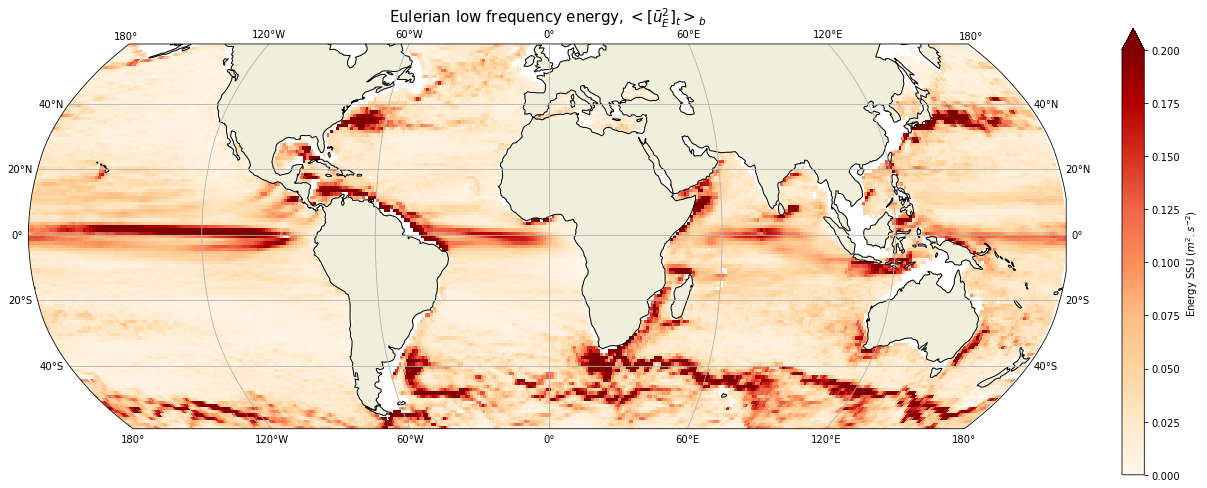

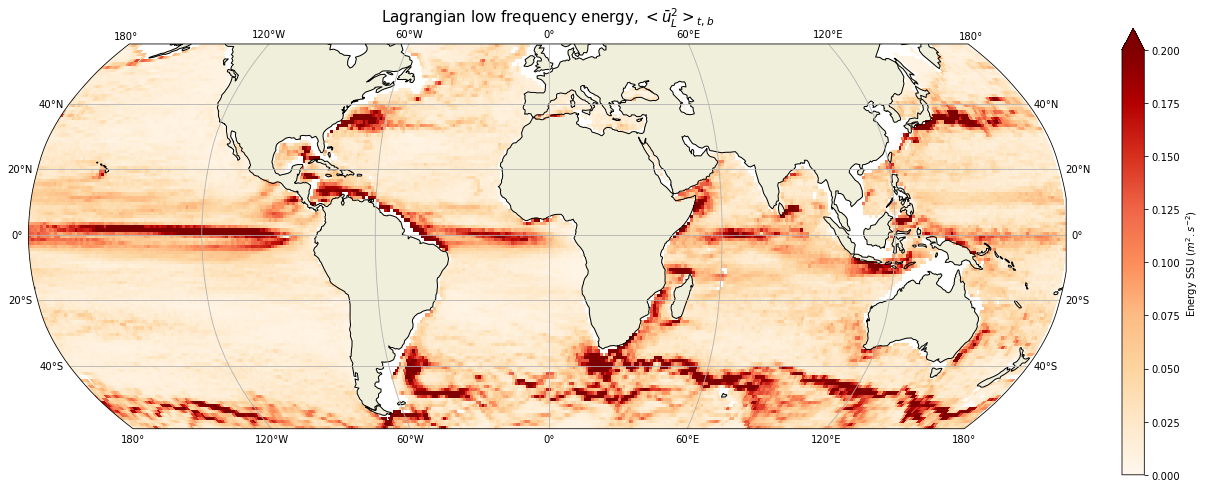

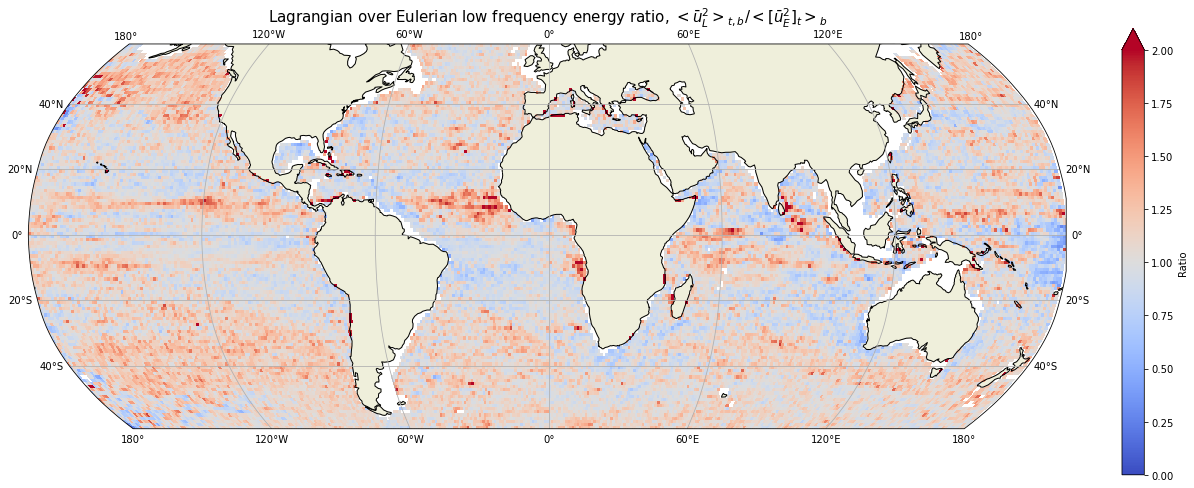

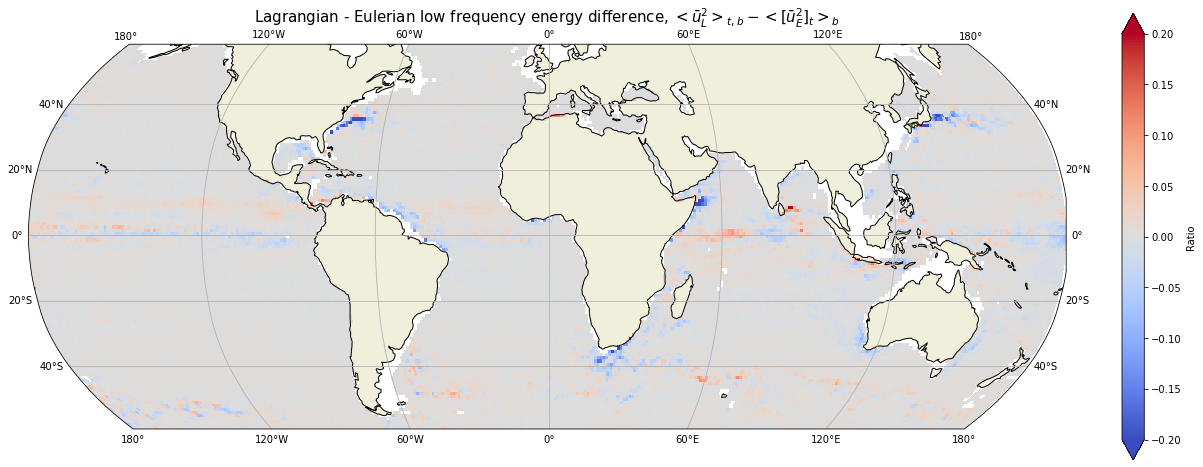

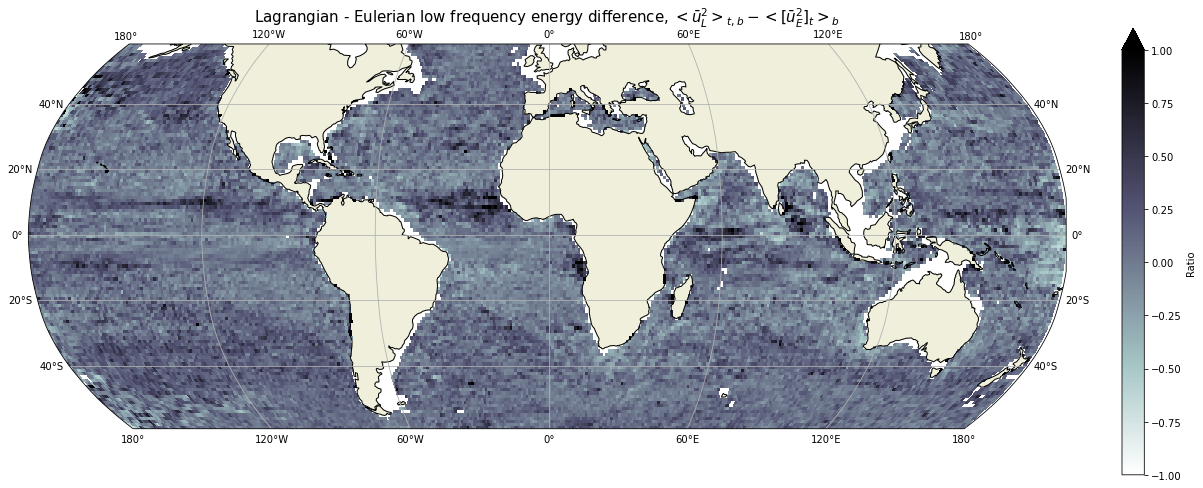

In [8]:
figsize = (20,20)
cmap = 'OrRd'
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low.E_energy_SSU,colmap=cmap,vlim=(0,0.2),**{'label':r'Energy SSU ($m^2.s^{-2}$)'})
ax.set_title(r'Eulerian low frequency energy, $<[\bar u_E^2]_t>_b$',size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low.L_energy_SSU,colmap=cmap,vlim=(0,0.2),**{'label':r'Energy SSU ($m^2.s^{-2}$)'})
ax.set_title(r'Lagrangian low frequency energy, $<\bar u_L^2>_{t,b}$',size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low.L_energy_SSU/ds_low.E_energy_SSU,colmap='coolwarm',vlim=(0,2),**{'label':'Ratio'})
ax.set_title(r'Lagrangian over Eulerian low frequency energy ratio, $<\bar u_L^2>_{t,b}/<[\bar u_E^2]_t>_b$'
             ,size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low.L_energy_SSU-ds_low.E_energy_SSU,colmap='coolwarm',vlim=(-0.2,0.2),**{'label':'Ratio'})
ax.set_title(r'Lagrangian - Eulerian low frequency energy difference, $<\bar u_L^2>_{t,b}-<[\bar u_E^2]_t>_b$'
             ,size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(((ds_low.L_energy_SSU-ds_low.E_energy_SSU)/ds_low.E_energy_SSU),colmap='bone_r',vlim=(-1,1),**{'label':'Ratio'})
ax.set_title(r'Lagrangian - Eulerian low frequency energy difference, $<\bar u_L^2>_{t,b}-<[\bar u_E^2]_t>_b$'
             ,size=15)

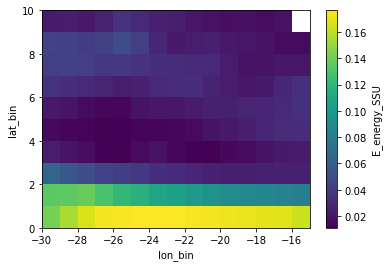

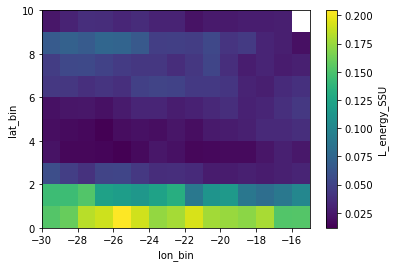

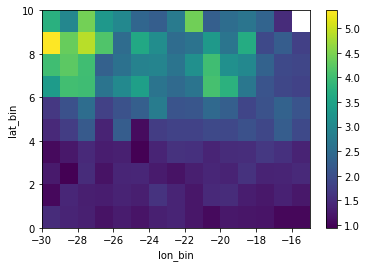

In [20]:
ds_low.sel(lon_bin=slice(-30,-15),lat_bin=slice(0,10)).E_energy_SSU.plot(x='lon_bin')
plt.figure()
ds_low.sel(lon_bin=slice(-30,-15),lat_bin=slice(0,10)).L_energy_SSU.plot(x='lon_bin')
plt.figure()
(ds_low.L_energy_SSV/ds_low.E_energy_SSV).sel(lon_bin=slice(-30,-15),lat_bin=slice(0,10)).plot(x='lon_bin')

Text(0.5, 1.0, 'Number of drifters per bin')

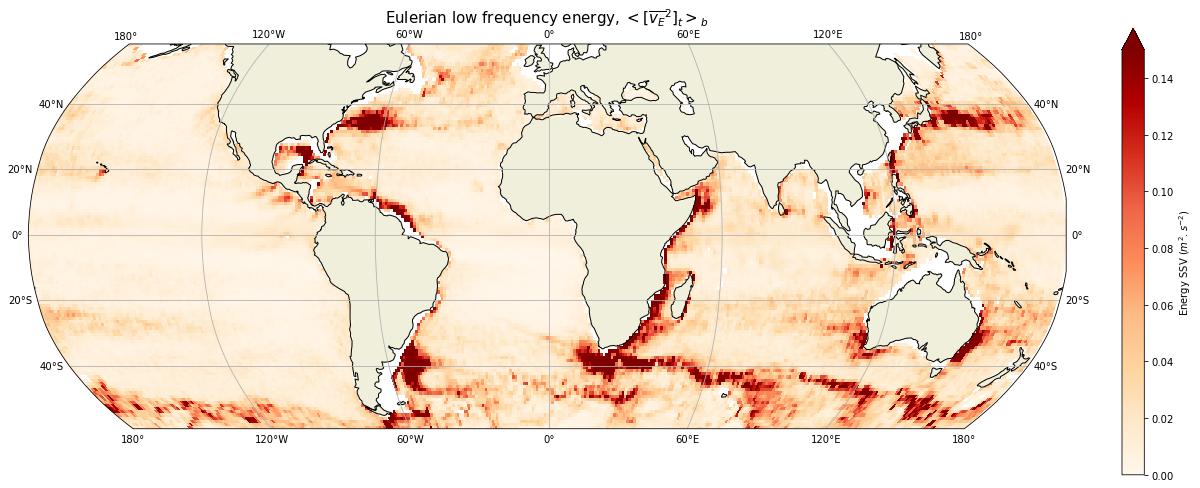

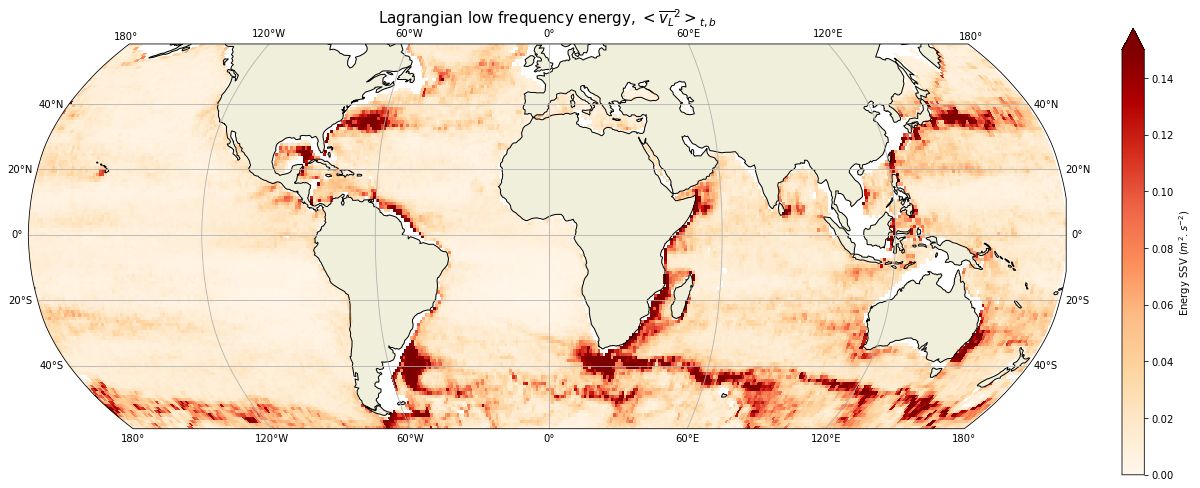

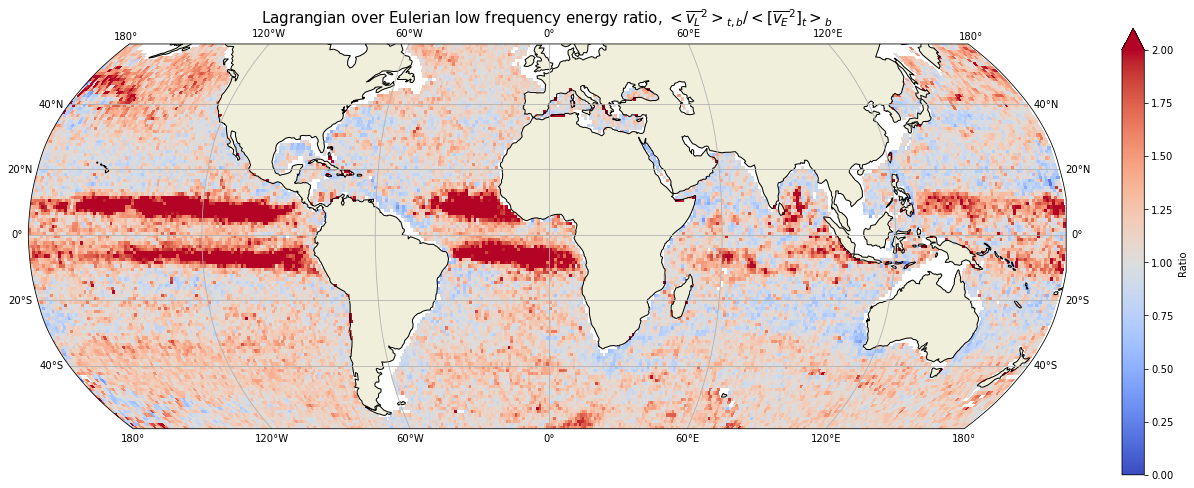

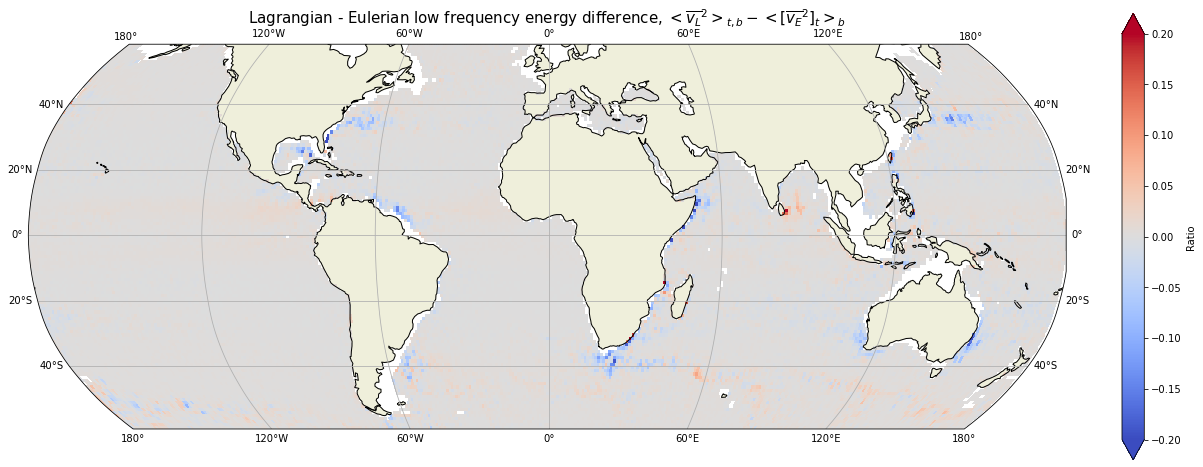

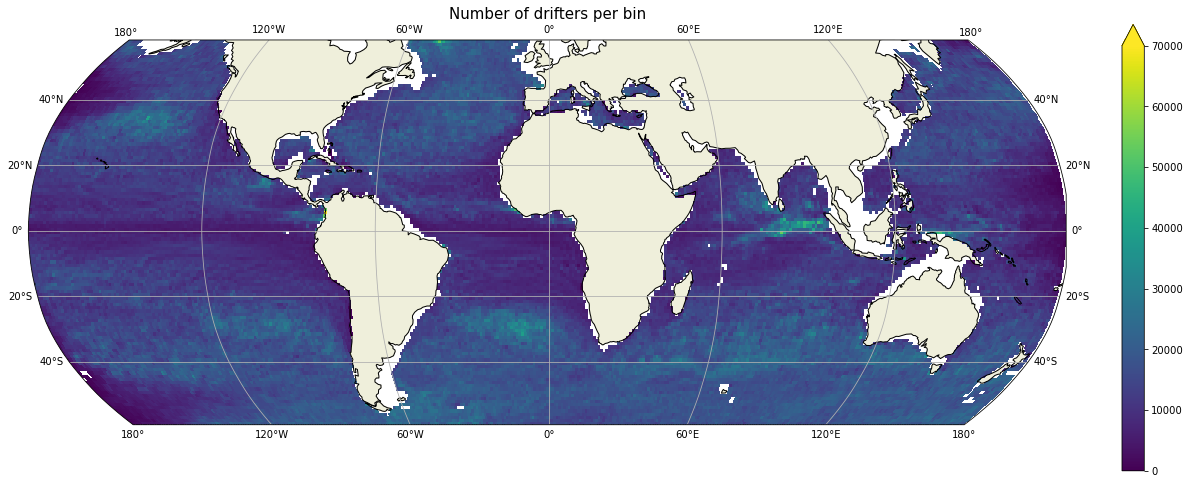

In [9]:
figsize = (20,20)
cmap = 'OrRd'
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low.E_energy_SSV,colmap=cmap,vlim=(0,0.15),**{'label':r'Energy SSV ($m^2.s^{-2}$)'})
ax.set_title(r'Eulerian low frequency energy, $<[\overline{v_E}^2]_t>_b$',size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low.L_energy_SSV,colmap=cmap,vlim=(0,0.15),**{'label':r'Energy SSV ($m^2.s^{-2}$)'})
ax.set_title(r'Lagrangian low frequency energy, $<\overline{v_L}^2>_{t,b}$',size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low.L_energy_SSV/ds_low.E_energy_SSV,colmap='coolwarm',vlim=(0.,2),**{'label':'Ratio'})
ax.set_title(r'Lagrangian over Eulerian low frequency energy ratio, $<\overline{v_L}^2>_{t,b}/<[\overline{v_E}^2]_t>_b$'
             ,size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low.L_energy_SSV-ds_low.E_energy_SSV,colmap='coolwarm',vlim=(-0.2,0.2),**{'label':'Ratio'})
ax.set_title(r'Lagrangian - Eulerian low frequency energy difference, $<\overline{v_L}^2>_{t,b}-<[\overline{v_E}^2]_t>_b$'
             ,size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low.L_count,colmap='viridis',vlim=(0.,70000),**{'label': ''})
ax.set_title(r'Number of drifters per bin',size=15)

Text(0.5, 1.0, '$<\\overline{u_L}^2+\\overline{v_L}^2>_{t,b}-<[\\overline{u_E}^2+\\overline{v_E}^2]_t>_b$')

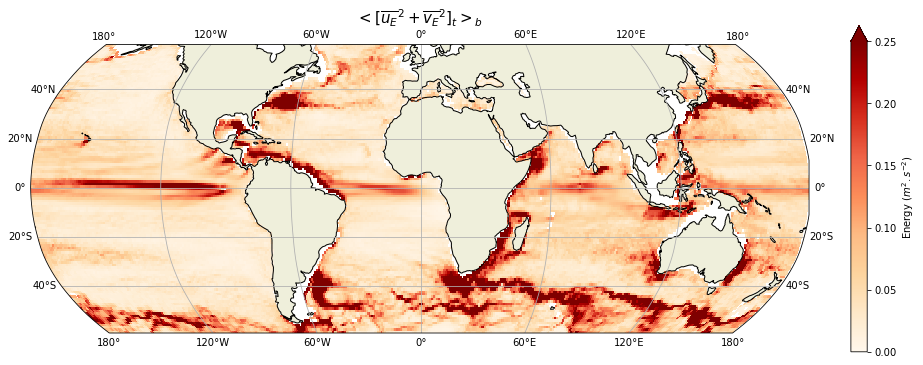

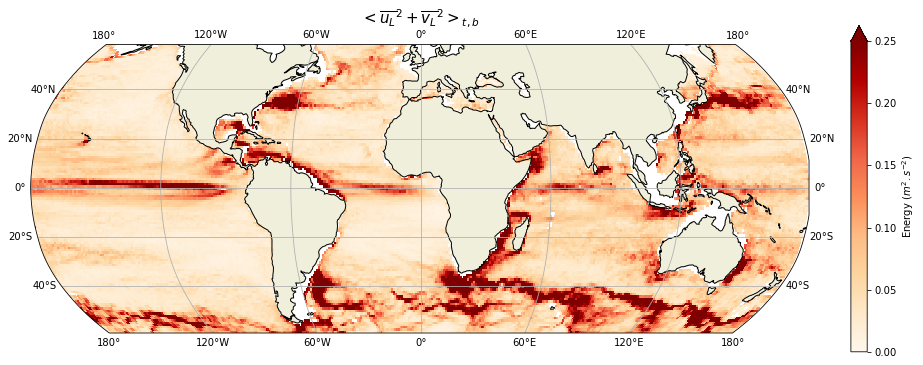

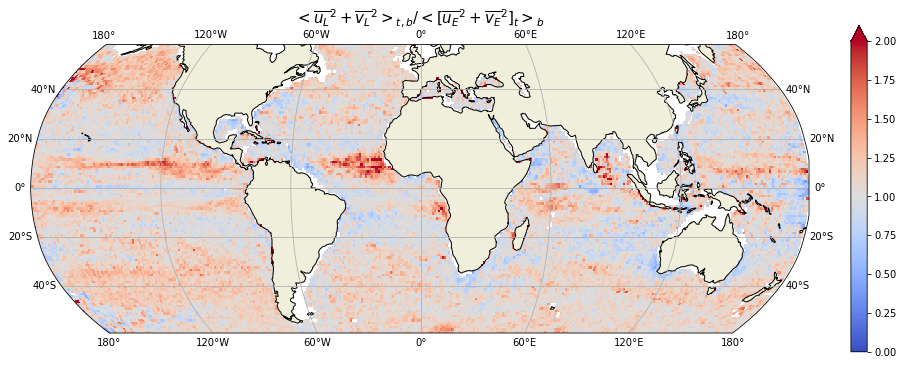

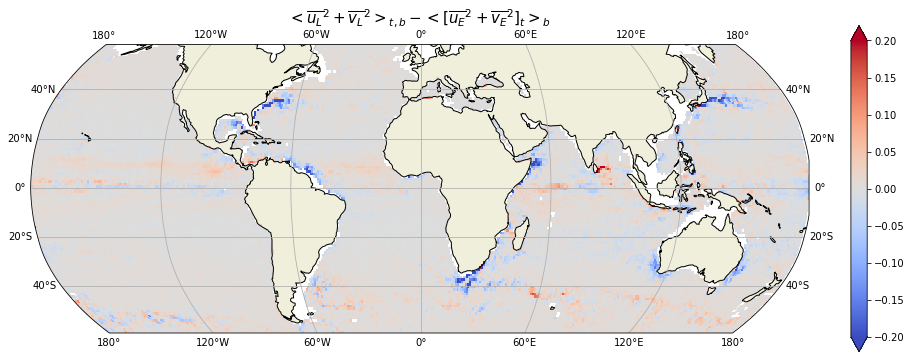

In [10]:
figsize = (15,6)
cmap = 'OrRd'
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low.E_energy,colmap=cmap,vlim=(0,0.25),**{'label':r'Energy ($m^2.s^{-2}$)'})
ax.set_title(r'$<[\overline{u_E}^2+\overline{v_E}^2]_t>_b$',size=15)
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_energy_low_mean0.png')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low.L_energy,colmap=cmap,vlim=(0,0.25),**{'label':r'Energy ($m^2.s^{-2}$)'})
ax.set_title(r'$<\overline{u_L}^2+\overline{v_L}^2>_{t,b}$',size=15)
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_energy_low_mean0.png')


fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low.L_energy/ds_low.E_energy,colmap='coolwarm',vlim=(0,2),**{'label':''})
ax.set_title(r'$<\overline{u_L}^2+\overline{v_L}^2>_{t,b}/<[\overline{u_E}^2+\overline{v_E}^2]_t>_b$'
             ,size=15)
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/LE_energy_low_mean0.png')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low.L_energy-ds_low.E_energy,colmap='coolwarm',vlim=(-0.2,0.2),**{'label':''})
ax.set_title(r'$<\overline{u_L}^2+\overline{v_L}^2>_{t,b}-<[\overline{u_E}^2+\overline{v_E}^2]_t>_b$'
             ,size=15)

### Variance

Text(0.5, 1.0, 'Lagrangian over Eulerian low frequency variance ratio, $<\\overline{u_L\\prime}^2>_{t,b}/<[\\overline{u_E\\prime}^2]_t>_b$')

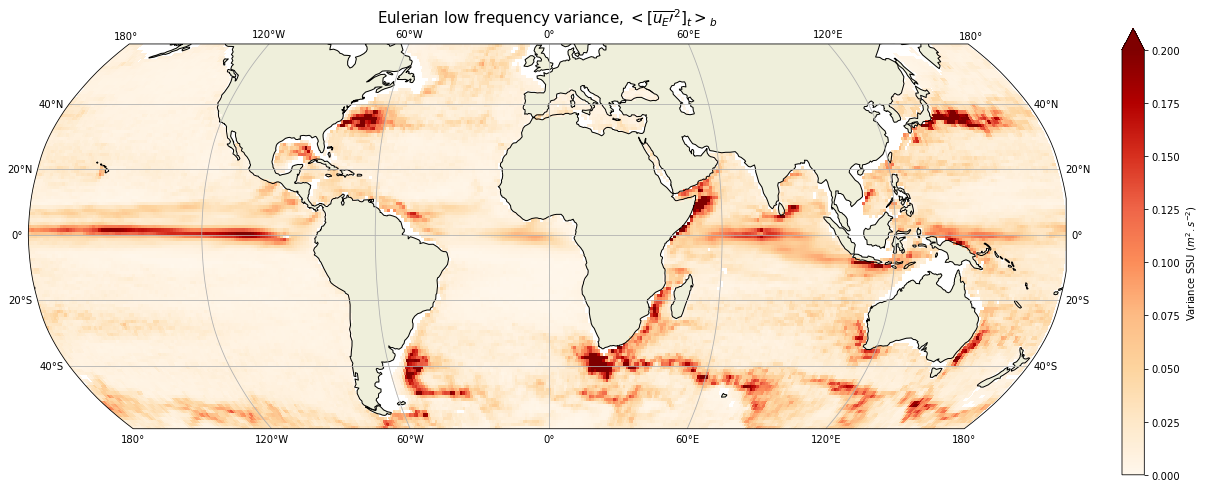

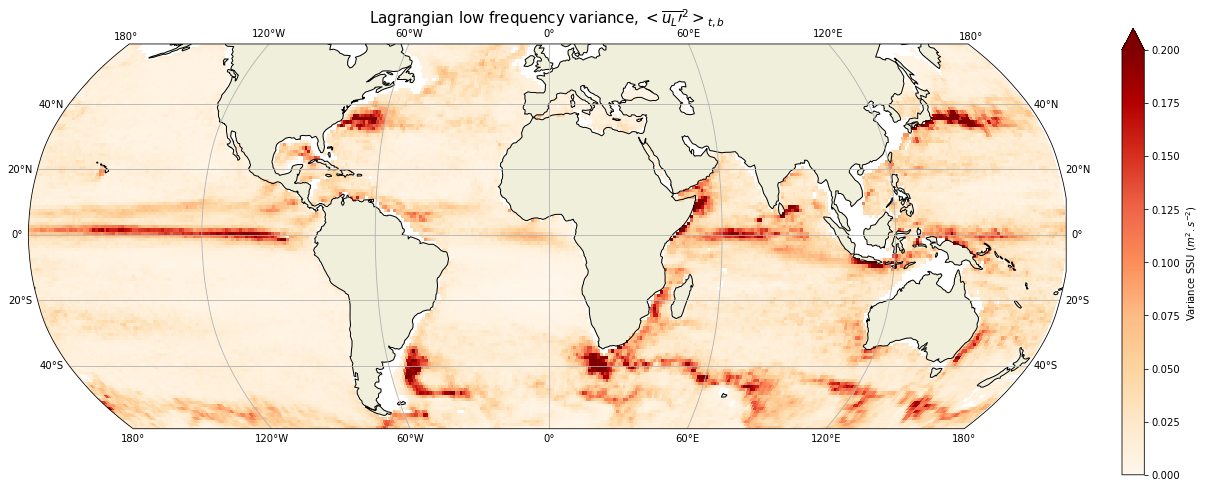

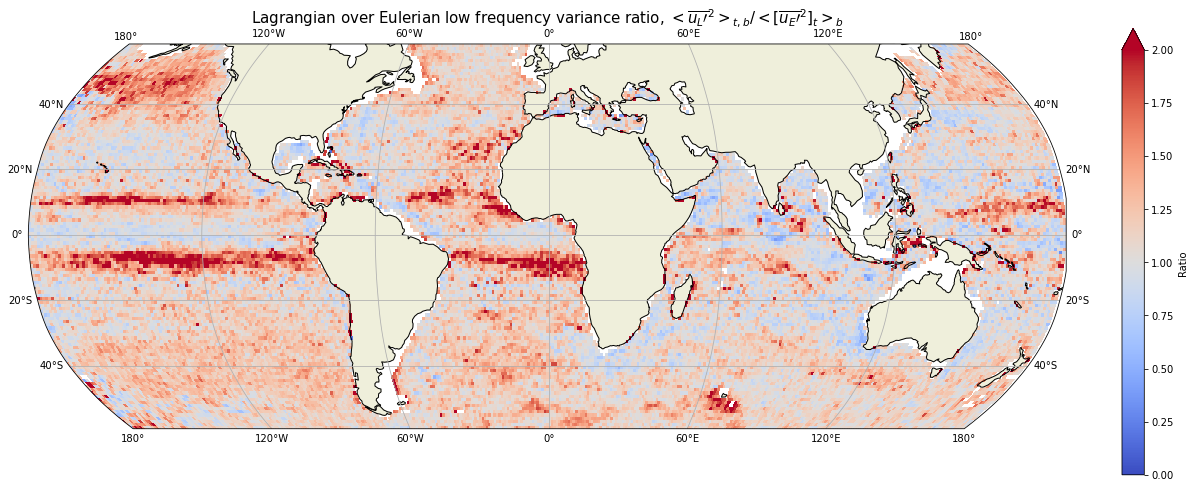

In [11]:
figsize = (20,20)
cmap = 'OrRd'
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low_var.E_energy_SSU,colmap=cmap,vlim=(0,0.2),**{'label':r'Variance SSU ($m^2.s^{-2}$)'})
ax.set_title(r'Eulerian low frequency variance, $<[\overline{u_E\prime}^2]_t>_b$',size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low_var.L_energy_SSU,colmap=cmap,vlim=(0,0.2),**{'label':r'Variance SSU ($m^2.s^{-2}$)'})
ax.set_title(r'Lagrangian low frequency variance, $<\overline{u_L\prime}^2>_{t,b}$',size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low_var.L_energy_SSU/ds_low_var.E_energy_SSU,colmap='coolwarm',vlim=(0,2),**{'label':'Ratio'})
ax.set_title(r'Lagrangian over Eulerian low frequency variance ratio, $<\overline{u_L\prime}^2>_{t,b}/<[\overline{u_E\prime}^2]_t>_b$'
             ,size=15)

Text(0.5, 1.0, 'Lagrangian over Eulerian low frequency variance ratio, $<\\overline{v_L\\prime}^2>_{t,b}/<[\\overline{v_E\\prime}^2]_t>_b$')

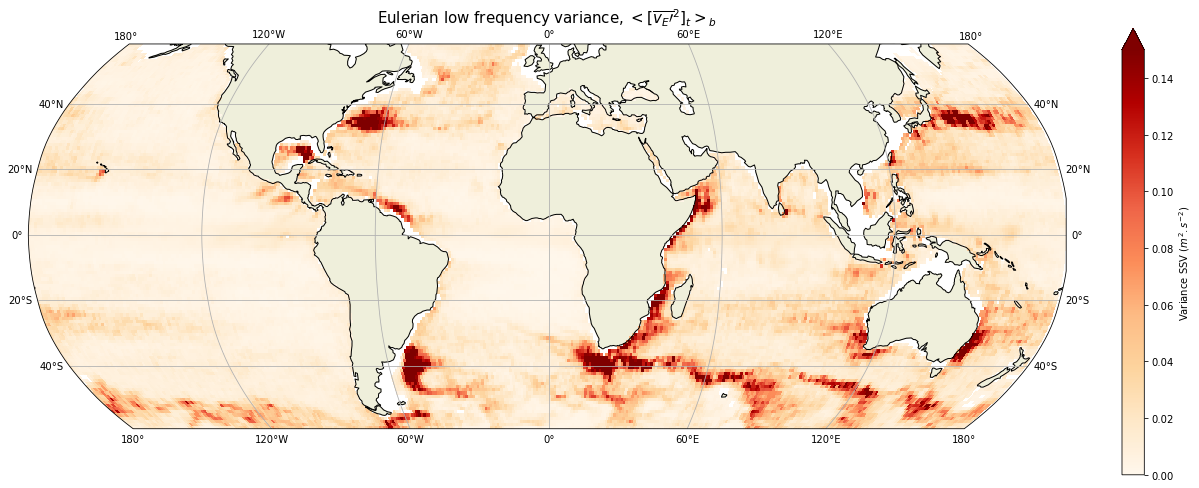

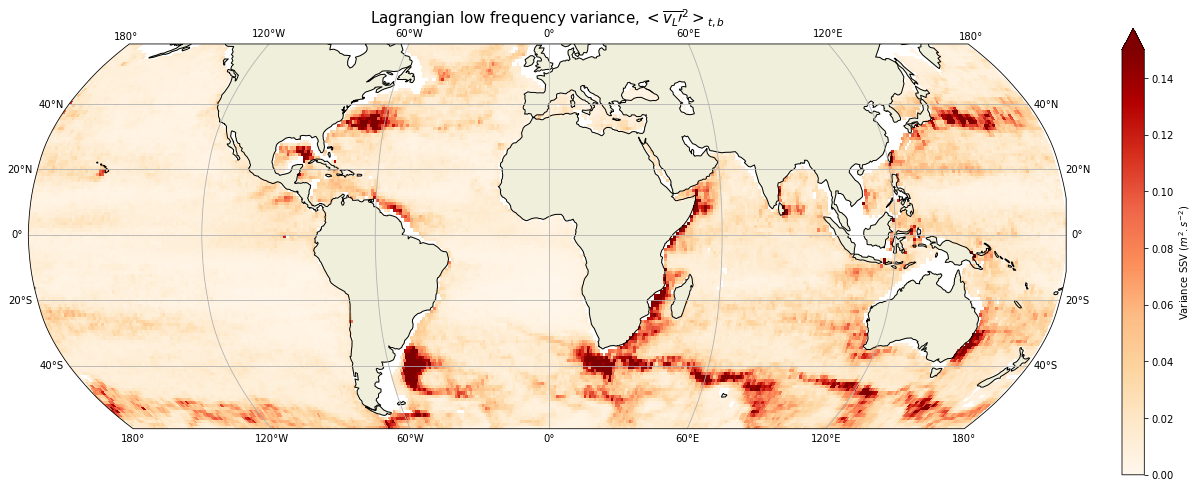

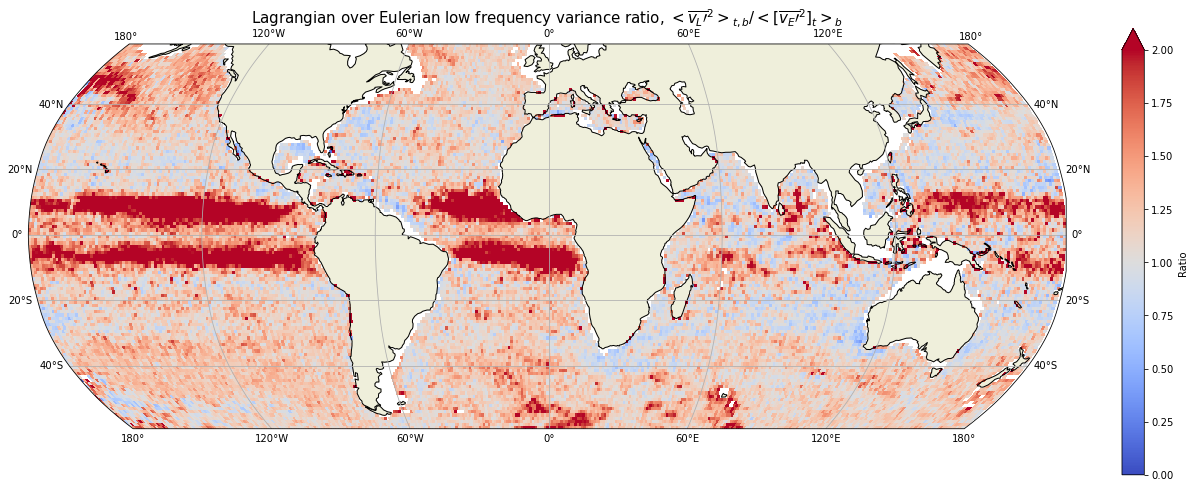

In [12]:
figsize = (20,20)
cmap = 'OrRd'
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low_var.E_energy_SSV,colmap=cmap,vlim=(0,0.15),**{'label':r'Variance SSV ($m^2.s^{-2}$)'})
ax.set_title(r'Eulerian low frequency variance, $<[\overline{v_E\prime}^2]_t>_b$',size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low_var.L_energy_SSV,colmap=cmap,vlim=(0,0.15),**{'label':r'Variance SSV ($m^2.s^{-2}$)'})
ax.set_title(r'Lagrangian low frequency variance, $<\overline{v_L\prime}^2>_{t,b}$',size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low_var.L_energy_SSV/ds_low_var.E_energy_SSV,colmap='coolwarm',vlim=(0.,2),**{'label':'Ratio'})
ax.set_title(r'Lagrangian over Eulerian low frequency variance ratio, $<\overline{v_L\prime}^2>_{t,b}/<[\overline{v_E\prime}^2]_t>_b$'
             ,size=15)



Text(0.5, 1.0, 'Lagrangian over Eulerian low frequency variance ratio,$<\\overline{u_L\\prime}^2+\\overline{v_L\\prime}^2>_{t,b}/<[\\overline{u_E\\prime}^2+\\overline{v_E\\prime}^2]_t>_b$')

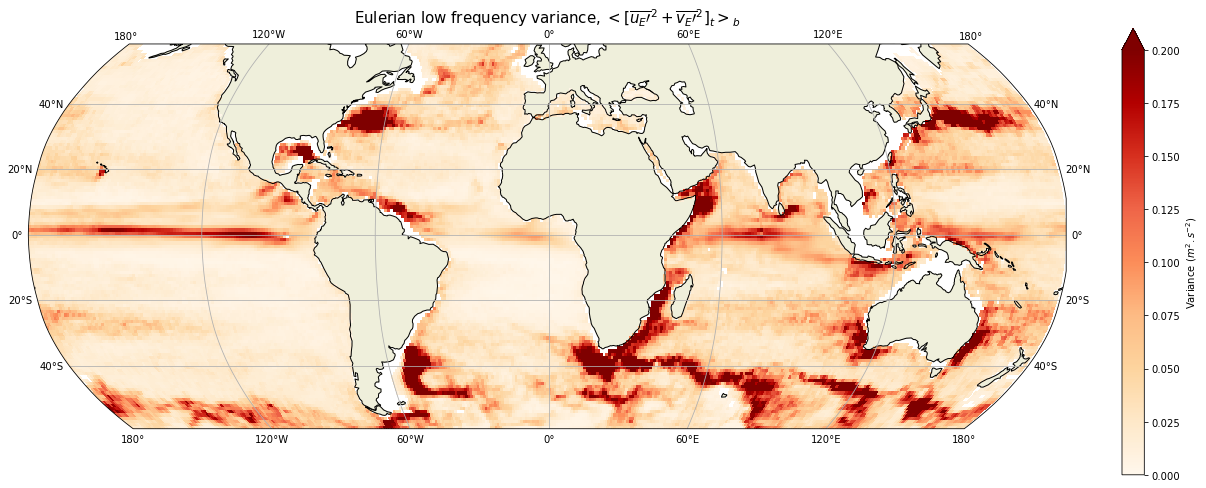

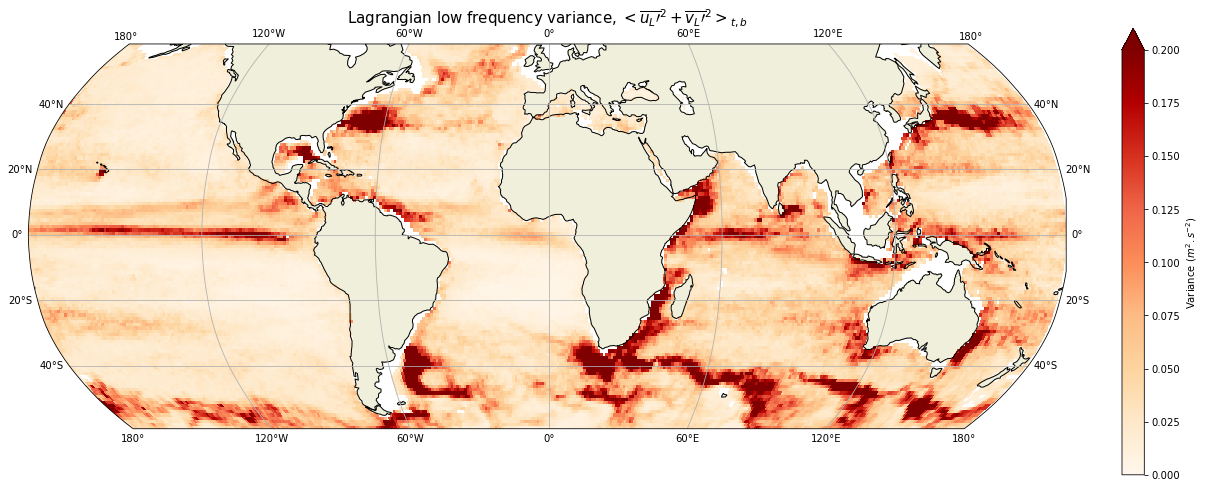

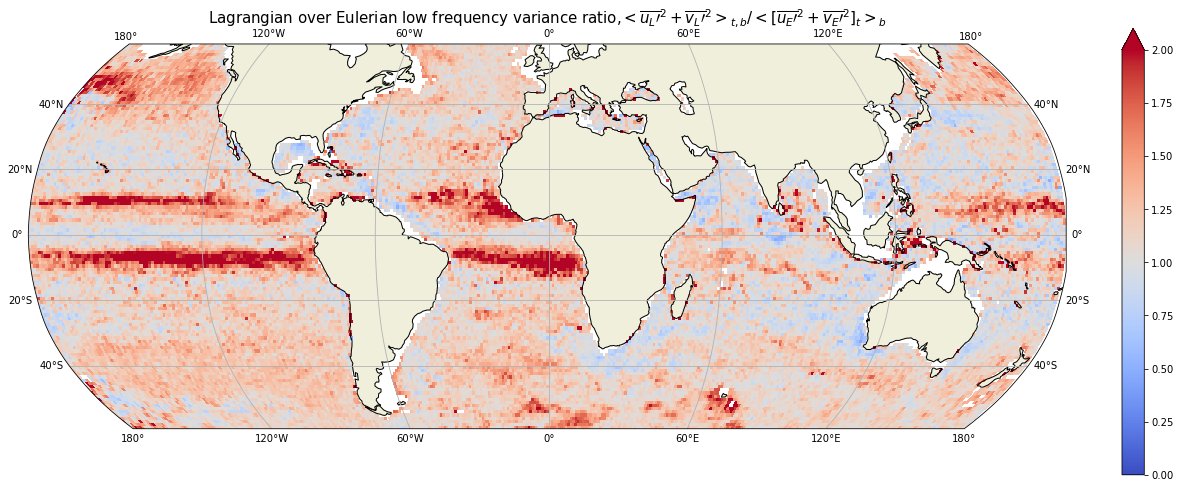

In [13]:
figsize = (20,20)
cmap = 'OrRd'
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low_var.E_energy,colmap=cmap,vlim=(0,0.2),**{'label':r'Variance ($m^2.s^{-2}$)'})
ax.set_title(r'Eulerian low frequency variance, $<[\overline{u_E\prime}^2+\overline{v_E\prime}^2]_t>_b$',size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low_var.L_energy,colmap=cmap,vlim=(0,0.2),**{'label':r'Variance ($m^2.s^{-2}$)'})
ax.set_title(r'Lagrangian low frequency variance, $<\overline{u_L\prime}^2+\overline{v_L\prime}^2>_{t,b}$',size=15)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low_var.L_energy/ds_low_var.E_energy,colmap='coolwarm',vlim=(0,2),**{'label':''})
ax.set_title(r'Lagrangian over Eulerian low frequency variance ratio,$<\overline{u_L\prime}^2+\overline{v_L\prime}^2>_{t,b}/<[\overline{u_E\prime}^2+\overline{v_E\prime}^2]_t>_b$'
             ,size=15)

### Energy and variance

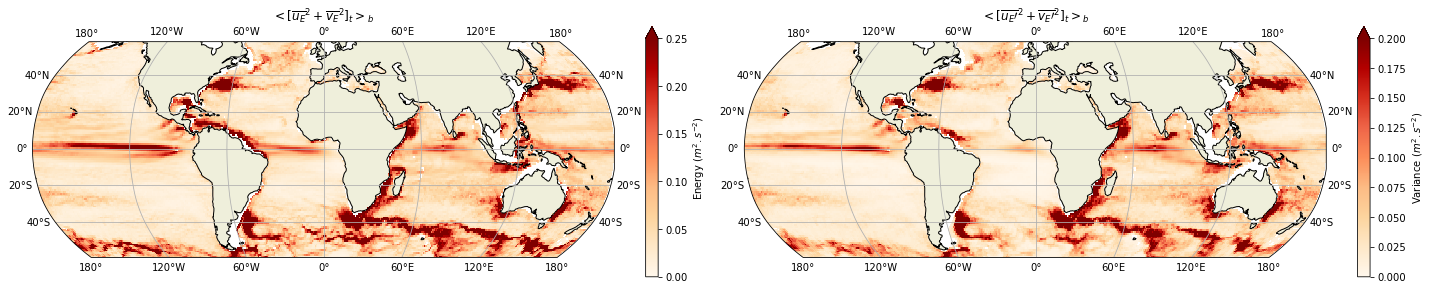

In [26]:
figsize = (20,5)
cmap = 'OrRd'
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low.E_energy,colmap=cmap,vlim=(0,0.25),**{'label':r'Energy ($m^2.s^{-2}$)'},axes=121)
ax.set_title(r'$<[\overline{u_E}^2+\overline{v_E}^2]_t>_b$',size=12)
fig,ax = plot_maps(ds_low_var.E_energy,colmap=cmap,vlim=(0,0.2),**{'label':r'Variance ($m^2.s^{-2}$)'},axes=122)
ax.set_title(r'$<[\overline{u_E\prime}^2+\overline{v_E\prime}^2]_t>_b$',size=12)
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_energy_low.png')

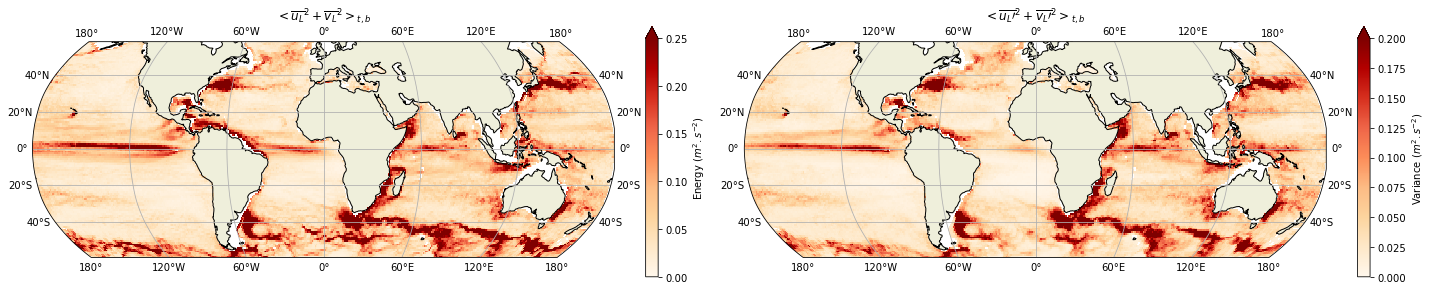

In [27]:
figsize = (20,5)
cmap = 'OrRd'
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low.L_energy,colmap=cmap,vlim=(0,0.25),**{'label':r'Energy ($m^2.s^{-2}$)'},axes=121)
ax.set_title(r'$<\overline{u_L}^2+\overline{v_L}^2>_{t,b}$',size=12)
fig,ax = plot_maps(ds_low_var.L_energy,colmap=cmap,vlim=(0,0.2),**{'label':r'Variance ($m^2.s^{-2}$)'},axes=122)
ax.set_title(r'$<\overline{u_L\prime}^2+\overline{v_L\prime}^2>_{t,b}$',size=12)
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_energy_low.png')

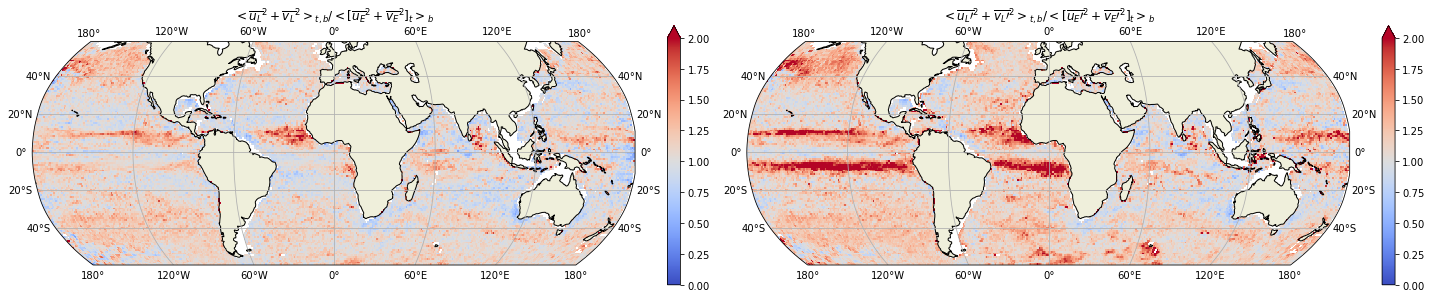

In [29]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(ds_low.L_energy/ds_low.E_energy,colmap='coolwarm',vlim=(0,2),**{'label':''},axes=121)
ax.set_title(r'$<\overline{u_L}^2+\overline{v_L}^2>_{t,b}/<[\overline{u_E}^2+\overline{v_E}^2]_t>_b$'
             ,size=12)
fig,ax = plot_maps(ds_low_var.L_energy/ds_low_var.E_energy,colmap='coolwarm',vlim=(0,2),**{'label':''},axes=122)
ax.set_title(r'$<\overline{u_L\prime}^2+\overline{v_L\prime}^2>_{t,b}/<[\overline{u_E\prime}^2+\overline{v_E\prime}^2]_t>_b$'
             ,size=12)
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/LE_energy_low.png')